# 🧠 Agentic Document Extraction for Tax Preparation

This notebook demonstrates how to use the `landingai-ade` Python package to extract structured financial information from mixed client documents using LandingAI's Agentic Document Extraction (ADE) service.

We'll walk through:
- Authenticating with the ADE API
- Categorizing different document types (pay stubs, bank statements, investment statements)
- Parsing documents to extract layout and content
- Defining custom schemas using `pydantic` for each document type
- Extracting structured financial data with visual grounding references
- Visualizing extraction results with bounding boxes

## 📦 0. Install ADE

Install necessary packages for document extraction and processing:

```bash
landingai-ade  # LandingAI ADE Python SDK
pillow         # For image processing
pymupdf        # For PDF processing
```

In [1]:
!pip install landingai-ade
!pip install pillow
!pip install pymupdf


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 🔐 1. Authenticate with ADE API

Set up your API credentials to access LandingAI's ADE service.

Obtain your API Key from the Visual Playground at https://va.landing.ai/settings/api-key

Read about options for setting your API key at https://docs.landing.ai/ade/agentic-api-key

For this example, we use environment variables to store credentials securely.

In [24]:
%env VISION_AGENT_API_KEY=YOUR_API_KEY_HERE

env: VISION_AGENT_API_KEY=YOUR_API_KEY_HERE


In [15]:
# Initialize the LandingAI ADE client
from landingai_ade import LandingAIADE

# Create client instance using credentials from environment variables
client = LandingAIADE()

## 📂 2. Understanding the Use Case: Tax Preparation

**Scenario:** You are an accountant preparing tax returns for multiple clients. Each client sends various financial documents—pay stubs, bank statements, investment statements—containing income and expense information.

**Challenge:** Different document types contain different fields. You need to:
1. Automatically categorize each document type
2. Extract the relevant financial data based on the document category
3. Maintain audit trails showing where each value came from

**Solution:** Use ADE to automatically categorize documents and apply document-specific extraction schemas.

### Preview a Sample Document

Let's first look at one of the documents to understand what we're working with.

Document: acc_statement.pdf
Document: bank.pdf
Document: earnings.pdf
Showing tax_preparation/earnings.pdf


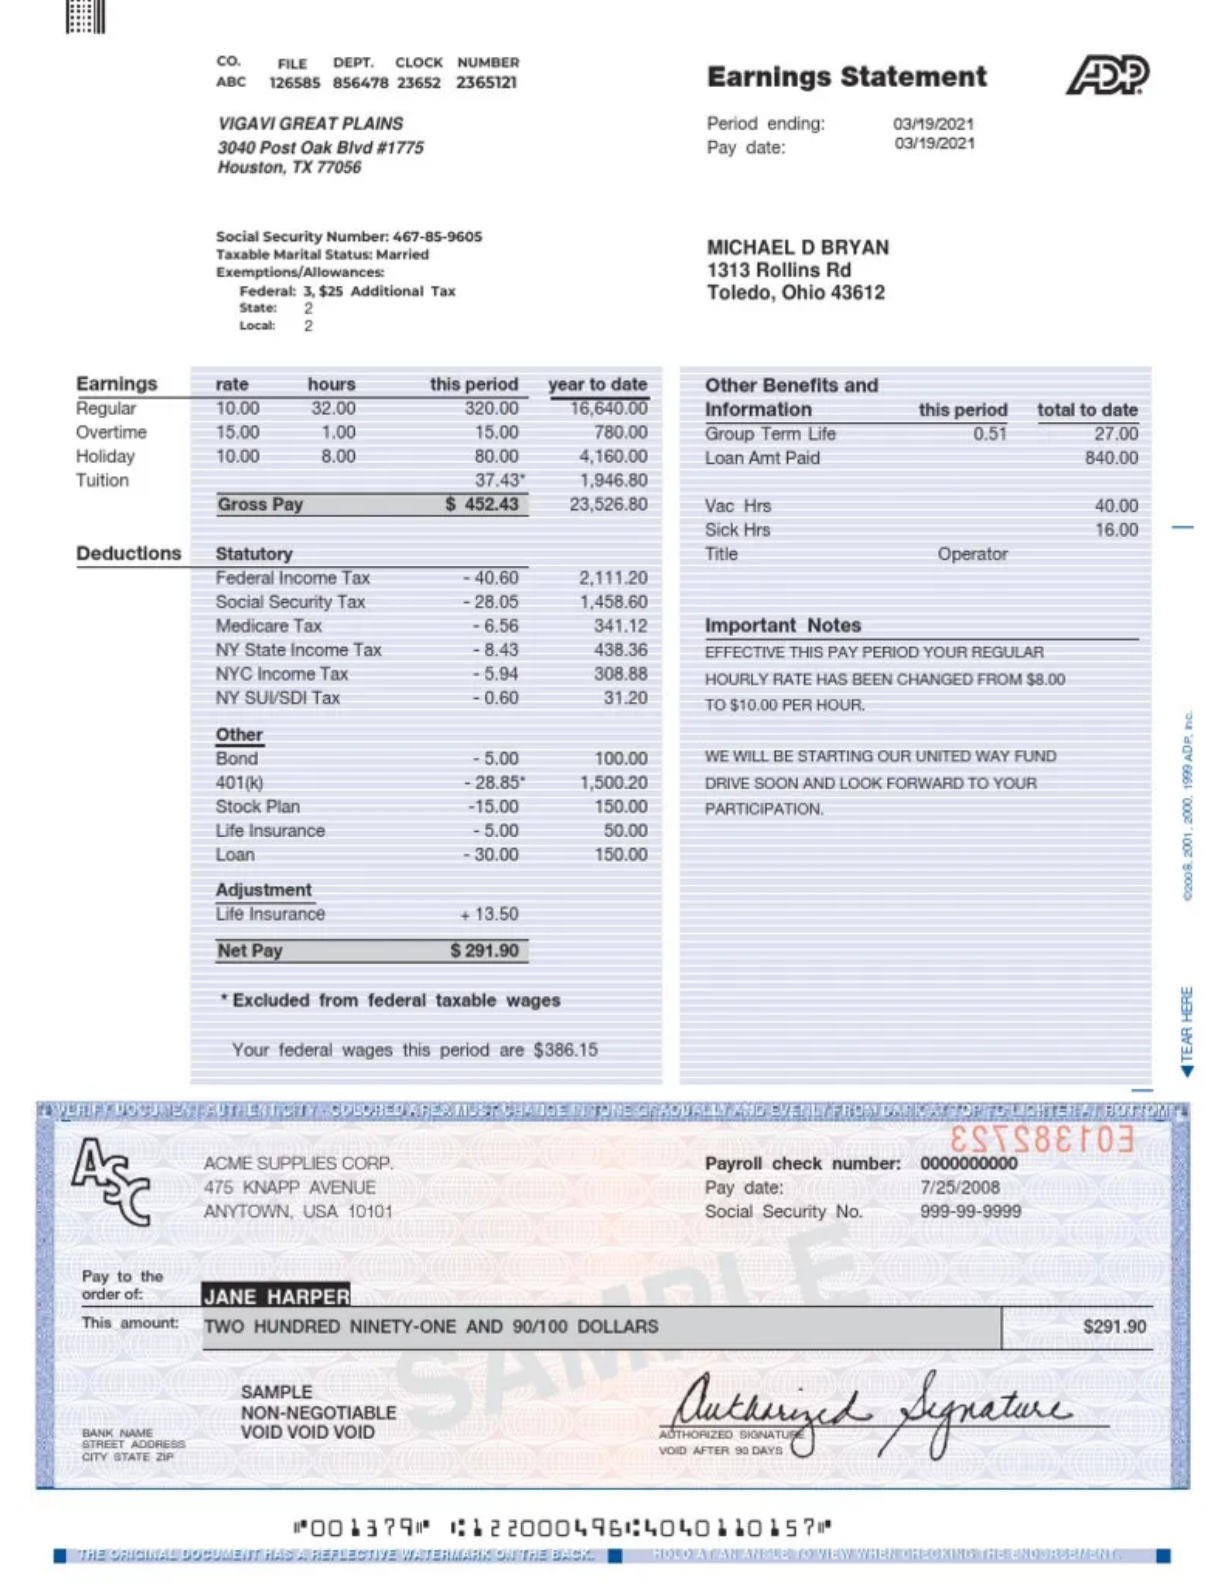

In [16]:
# Import required libraries
from pathlib import Path
import pymupdf  # For PDF processing
from PIL import Image  # For image handling
from IPython.display import display

# Define the folder containing client documents
documents_folder = Path("tax_preparation")

# List all supported document files
for filepath in documents_folder.glob("*"):
    print(f"Document: {filepath.name}")

# Open and display a sample PDF document (first page)
pdf = pymupdf.open(filepath)
pix = pdf[0].get_pixmap(matrix=pymupdf.Matrix(2, 2))  # Render at 2x resolution
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

print(f"Showing {filepath}")
display(img)

### Document Categorization Schema

The document above appears to be a pay stub with employee name, pay period, gross pay, and net pay.

Since different document types require different extraction fields, we first need to **categorize** each document.

We define three categories:
- **pay_stub**: Employee earnings statements
- **bank_statement**: Account balances and transactions
- **investment_statement**: Portfolio values and changes

Below, we use Pydantic to define a schema for document type classification:

In [17]:
# Import Pydantic for schema definition
from typing import Literal
from pydantic import BaseModel, Field

# Define document type classification schema
class DocType(BaseModel):
    type: Literal["pay_stub", "bank_statement", "investment_statement"] = Field(
        description="The type of the document.",
        title="Document Type",
    )

## 🧩 3. Define Document-Specific Extraction Schemas

Now we define what financial data to extract from each document type:

- **Pay Stub**: Employee name, pay period, gross pay, net pay
- **Bank Statement**: Bank name, account number, current balance
- **Investment Statement**: Investment year, total investment, changes in value

Each schema uses descriptive fields that guide the extraction process:

In [18]:
from landingai_ade.lib import pydantic_to_json_schema

# Schema for Bank Statements
class BankStatementSchema(BaseModel):
    bank_name: str = Field(
        description="The name of the bank.",
        title="Bank Name",
    )
    account_number: str = Field(
        description="The bank account number.",
        title="Account Number",
    )
    balance: float = Field(
        description="The current balance of the bank account.",
        title="Balance",
    )

# Schema for Investment Statements
class InvestmentStatementSchema(BaseModel):
    investment_year: int = Field(
        description="The year of the investment statement.",
        title="Investment Year",
    )
    total_investment: float = Field(
        description="The total amount invested.",
        title="Total Investment",
    )
    changes_in_value: float = Field(
        description="The changes in the value of the investments.",
        title="Changes in Value",
    )

# Schema for Pay Stubs
class PaymentStubSchema(BaseModel):
    employee_name: str = Field(
        description="The name of the employee.",
        title="Employee Name",
    )
    pay_period: str = Field(
        description="The pay period for the stub.",
        title="Pay Period",
    )
    gross_pay: float = Field(
        description="The gross pay amount.",
        title="Gross Pay",
    )
    net_pay: float = Field(
        description="The net pay amount after deductions.",
        title="Net Pay",
    )

# Map document types to their corresponding schemas
schema_per_doc_type = {
    "bank_statement": BankStatementSchema,
    "investment_statement": InvestmentStatementSchema,
    "pay_stub": PaymentStubSchema,
}

# Convert the document type schema to JSON format for API calls
doc_type_json_schema = pydantic_to_json_schema(DocType)

## 🚀 4. Parse and Categorize Documents

Now we process each document in two steps:
1. **Parse** the document to extract its layout and content as markdown
2. **Extract** the document type using our categorization schema

This workflow allows us to identify what kind of document we're dealing with before extracting specific fields.

To learn more about parsing, visit https://docs.landing.ai/ade/ade-parse-docs

In [19]:
from landingai_ade.types import ParseResponse, ExtractResponse

# Dictionary to store document types and parse results
document_types = {}

# Process each document in the folder
for document in documents_folder.glob("*"):
    print(f"Processing document: {document.name}")
    
    # Step 1: Parse the document to extract layout and content
    parse_result: ParseResponse = client.parse(
        document=document, 
        model="dpt-2-latest"
    )
    print("Parsing completed.")

    # Step 2: Extract document type using the categorization schema
    print("Extracting Document Type...")
    extraction_result: ExtractResponse = client.extract(
        schema=doc_type_json_schema, 
        markdown=parse_result.markdown
    )
    doc_type = extraction_result.extraction["type"]
    print("Document Type Extraction:", doc_type)

    # Store results for later use
    document_types[document] = {
        "document_type": doc_type,
        "parse_result": parse_result
    }

Processing document: acc_statement.pdf
Parsing completed.
Extracting Document Type...
Document Type Extraction: investment_statement
Processing document: bank.pdf
Parsing completed.
Extracting Document Type...
Document Type Extraction: bank_statement
Processing document: earnings.pdf
Parsing completed.
Extracting Document Type...
Document Type Extraction: pay_stub


## 📊 5. Extract Financial Data Based on Document Type

Now that we know each document's type, we can apply the appropriate extraction schema to get the specific financial fields we need.

Each extraction includes:
- **extraction**: The structured data values
- **extraction_metadata**: References showing where each value was found in the document

Now that we have each document category we can use extract again to get all the data depending on their schema:

In [20]:
# Dictionary to store extraction results
document_extractions = {}

# Extract financial data from each document using its specific schema
for document, extraction in document_types.items():
    print(f"Processing document: {document.name}")

    # Get the appropriate schema for this document type
    json_schema = pydantic_to_json_schema(
        schema_per_doc_type[extraction["document_type"]]
    )
    
    # Extract structured data using the schema
    extraction_result: ExtractResponse = client.extract(
        schema=json_schema, 
        markdown=extraction["parse_result"].markdown
    )
    print("Detailed Extraction:", extraction_result.extraction)

    # Store extraction results
    document_extractions[document] = {
        "extraction": extraction_result.extraction,
        "extraction_metadata": extraction_result.extraction_metadata,
    }

print(document_extractions)

Processing document: acc_statement.pdf
Detailed Extraction: {'investment_year': 2015, 'total_investment': 274222.2, 'changes_in_value': 19058.07}
Processing document: bank.pdf
Detailed Extraction: {'bank_name': 'Royal Bank of Canada', 'account_number': '02782-5094431', 'balance': 3664.79}
Processing document: earnings.pdf
Detailed Extraction: {'employee_name': 'MICHAEL D BRYAN', 'pay_period': '2021-03-19', 'gross_pay': 452.43, 'net_pay': 291.9}
{PosixPath('tax_preparation/acc_statement.pdf'): {'extraction': {'investment_year': 2015, 'total_investment': 274222.2, 'changes_in_value': 19058.07}, 'extraction_metadata': {'investment_year': {'value': 2015, 'references': ['d9b19fac-1f80-4890-b10c-9783a4c1f526']}, 'total_investment': {'value': 274222.2, 'references': ['0-l']}, 'changes_in_value': {'value': 19058.07, 'references': ['0-j']}}}, PosixPath('tax_preparation/bank.pdf'): {'extraction': {'bank_name': 'Royal Bank of Canada', 'account_number': '02782-5094431', 'balance': 3664.79}, 'extra

## 🎨 6. Visualize Parsing Results with Bounding Boxes

Let's visualize all the parsed document chunks with color-coded bounding boxes to see how ADE identified different content types (text, tables, figures, etc.).

This helps us understand the document structure and verify that parsing captured all relevant content.

Visualizing document: acc_statement.pdf
Annotated image saved to: results/acc_statement/page_1_annotated.png
Annotated image saved to: results/acc_statement/page_2_annotated.png
Annotated image saved to: results/acc_statement/page_3_annotated.png
Annotated image saved to: results/acc_statement/page_4_annotated.png
Annotated image saved to: results/acc_statement/page_5_annotated.png
Annotated image saved to: results/acc_statement/page_6_annotated.png
Annotated image saved to: results/acc_statement/page_7_annotated.png
Annotated image saved to: results/acc_statement/page_8_annotated.png
Annotated image saved to: results/acc_statement/page_9_annotated.png
Annotated image saved to: results/acc_statement/page_10_annotated.png
Annotated image saved to: results/acc_statement/page_11_annotated.png
Annotated image saved to: results/acc_statement/page_12_annotated.png
Annotated image saved to: results/acc_statement/page_13_annotated.png
Annotated image saved to: results/acc_statement/page_14_ann

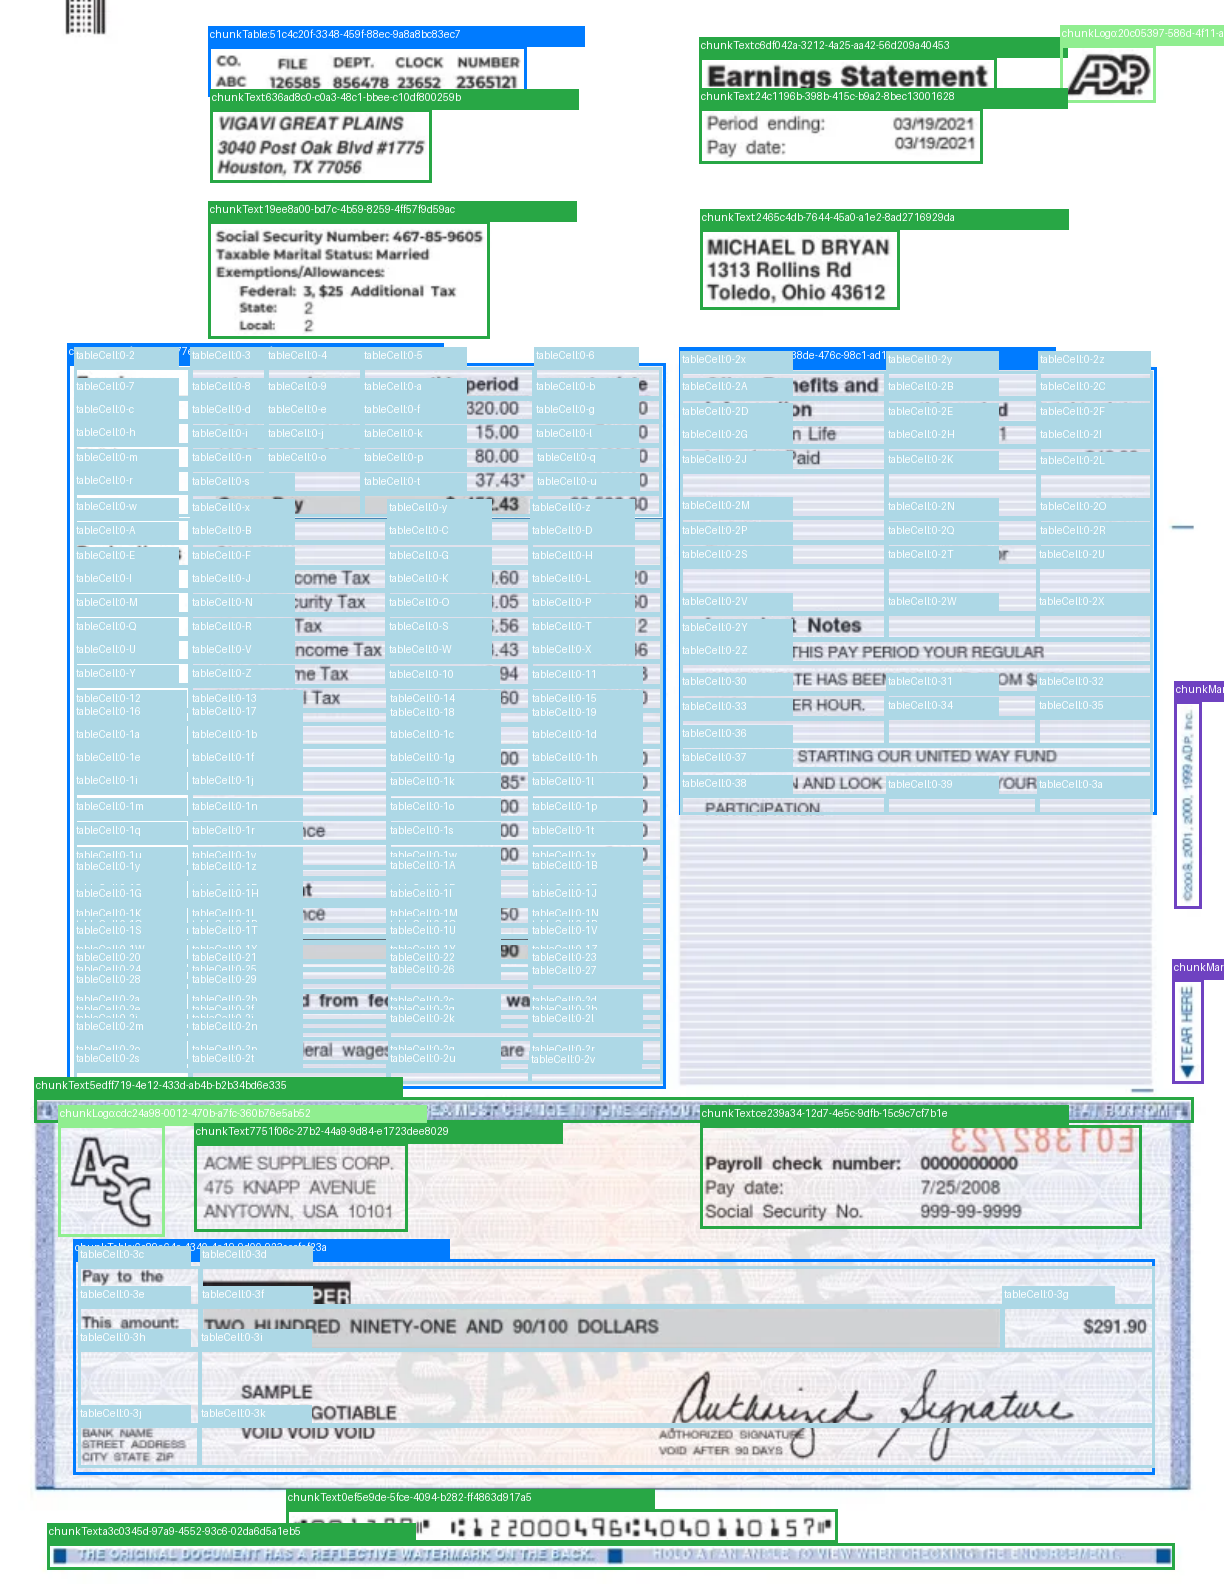

In [21]:
import os
from PIL import ImageDraw

# Define color scheme for different chunk types
CHUNK_TYPE_COLORS = {
    "chunkText": (40, 167, 69),        # Green
    "chunkTable": (0, 123, 255),       # Blue
    "chunkMarginalia": (111, 66, 193), # Purple
    "chunkFigure": (255, 0, 255),      # Magenta
    "chunkLogo": (144, 238, 144),      # Light green
    "chunkCard": (255, 165, 0),        # Orange
    "chunkAttestation": (0, 255, 255), # Cyan
    "chunkScanCode": (255, 193, 7),    # Yellow
    "chunkForm": (220, 20, 60),        # Red
    "tableCell": (173, 216, 230),      # Light blue
    "table": (70, 130, 180),           # Steel blue
}

def draw_bounding_boxes(groundings, document_path, base_path="."):
    """
    Draw bounding boxes on document images to visualize parsed chunks.
    
    Args:
        groundings: Dictionary of grounding objects with chunk locations
        document_path: Path to the original document
        base_path: Directory to save annotated images
    """
    def create_annotated_image(image, groundings, page_num=0):
        """Create an annotated image with grounding boxes and labels."""
        annotated_img = image.copy()
        draw = ImageDraw.Draw(annotated_img)

        img_width, img_height = image.size

        groundings_found = 0
        for gid, grounding in groundings.items():
            # Check if grounding belongs to this page (for multi-page PDFs)
            if grounding.page != page_num:
                continue

            groundings_found += 1
            box = grounding.box

            # Extract normalized coordinates from box
            left, top, right, bottom = box.left, box.top, box.right, box.bottom

            # Convert normalized coordinates to pixel coordinates
            x1 = int(left * img_width)
            y1 = int(top * img_height)
            x2 = int(right * img_width)
            y2 = int(bottom * img_height)

            # Draw bounding box with color based on chunk type
            color = CHUNK_TYPE_COLORS.get(grounding.type, (128, 128, 128))
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

            # Draw label background and text
            label = f"{grounding.type}:{gid}"
            label_y = max(0, y1 - 20)
            draw.rectangle([x1, label_y, x1 + len(label) * 8, y1], fill=color)
            draw.text((x1 + 2, label_y + 2), label, fill=(255, 255, 255))

        if groundings_found == 0:
            return None
        return annotated_img

    # Handle PDF documents
    if document_path.suffix.lower() == '.pdf':
        pdf = pymupdf.open(document_path)
        total_pages = len(pdf)

        for page_num in range(total_pages):
            page = pdf[page_num]
            pix = page.get_pixmap(matrix=pymupdf.Matrix(2, 2))  # 2x scaling
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

            # Create and save annotated image for this page
            annotated_img = create_annotated_image(img, groundings, page_num)
            if annotated_img is not None:
                annotated_path = f"{base_path}/page_{page_num + 1}_annotated.png"
                annotated_img.save(annotated_path)
                print(f"Annotated image saved to: {annotated_path}")

        pdf.close()
    else:
        # Handle image files directly
        img = Image.open(document_path)
        if img.mode != "RGB":
            img = img.convert("RGB")

        # Create and save annotated image
        annotated_img = create_annotated_image(img, groundings)
        annotated_path = "page_annotated.png"
        annotated_img.save(annotated_path)
        print(f"Annotated image saved to: {annotated_path}")

    return img

# Combine all extraction data
final_extractions = {}

for document, extraction in document_extractions.items():
    final_extractions[document] = {
        **extraction,
        **document_types[document],
    }

# Visualize all parsed chunks for each document
for document, extraction in final_extractions.items():
    print(f"Visualizing document: {document.name}")
    base_path = f"results/{document.stem}"
    os.makedirs(base_path, exist_ok=True)
    draw_bounding_boxes(
        extraction["parse_result"].grounding, 
        document, 
        base_path=base_path
    )

# Display the last annotated image
Image.open(f"{base_path}/page_1_annotated.png")

## 🎯 7. Visualize Extracted Fields Only

Now let's create a more focused visualization showing **only** the regions where we extracted financial data.

This is useful for:
- Verifying extraction accuracy
- Maintaining audit trails
- Quickly reviewing what data was captured

In [22]:
# Visualize only the extracted field locations
for document, extraction in final_extractions.items():
    print(f"Visualizing document: {document.name}")
    base_path = f"results_extracted/{document.stem}"
    os.makedirs(base_path, exist_ok=True)

    # Collect groundings only for extracted fields
    document_grounds = {}
    for label, metadata_value in extraction["extraction_metadata"].items():
        # Get the first reference chunk for each extracted field
        chunk_id = metadata_value["references"][0]
        grounding = extraction["parse_result"].grounding[chunk_id]
        document_grounds[chunk_id] = grounding

    # Draw bounding boxes only for extracted fields
    draw_bounding_boxes(document_grounds, document, base_path=base_path)

Visualizing document: acc_statement.pdf
Annotated image saved to: results_extracted/acc_statement/page_1_annotated.png
Visualizing document: bank.pdf
Annotated image saved to: results_extracted/bank/page_1_annotated.png
Visualizing document: earnings.pdf
Annotated image saved to: results_extracted/earnings/page_1_annotated.png


Extracted field visualizations for all documents:

acc_statement:


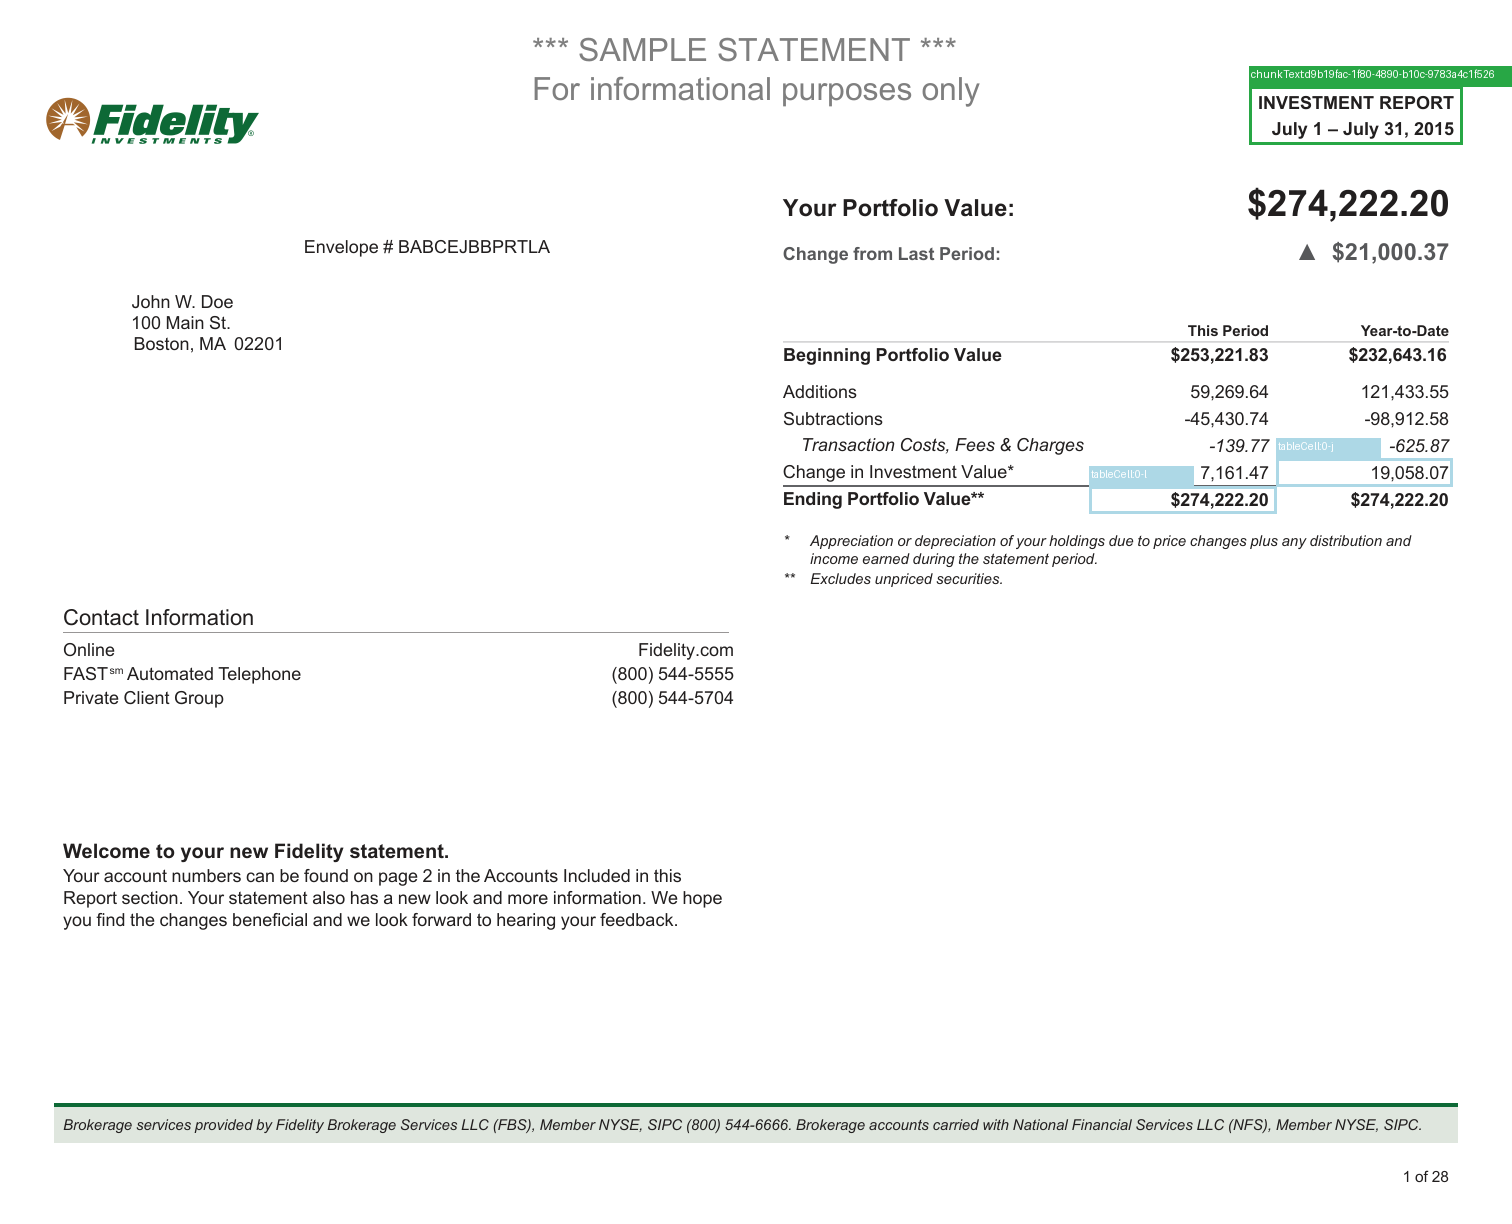


bank:


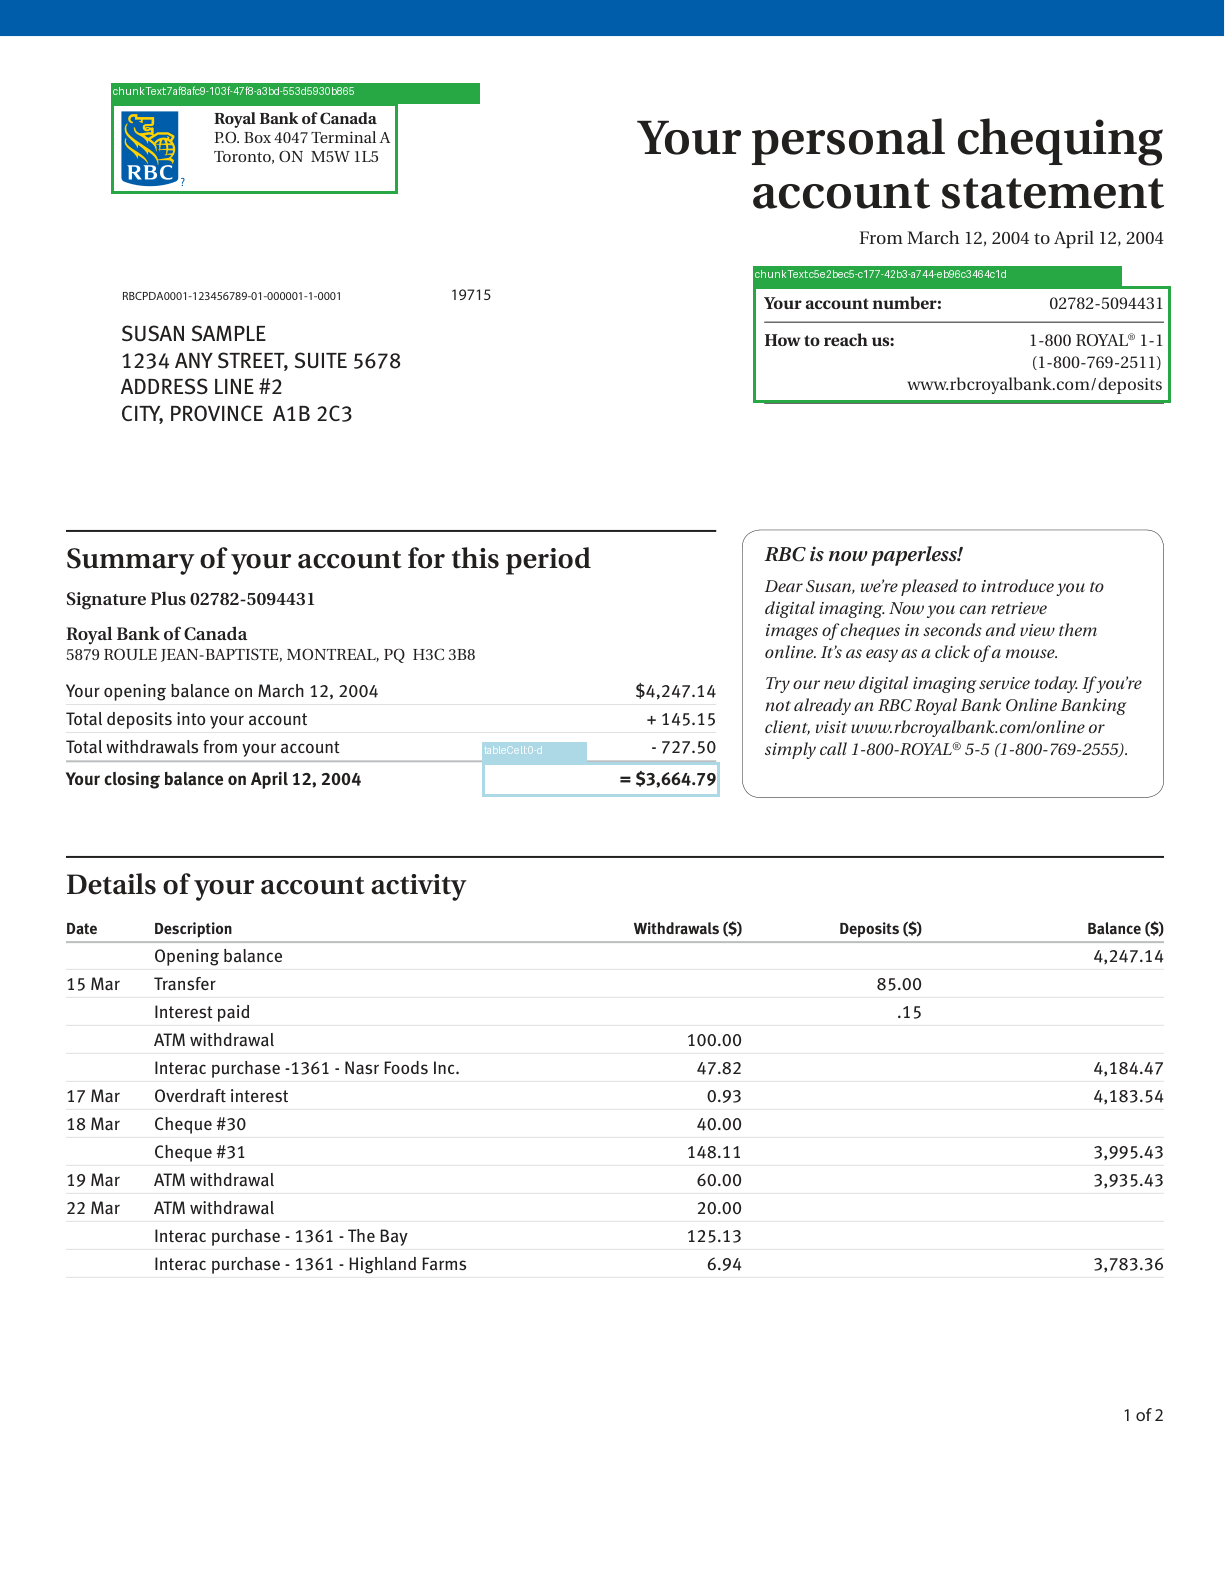


earnings:


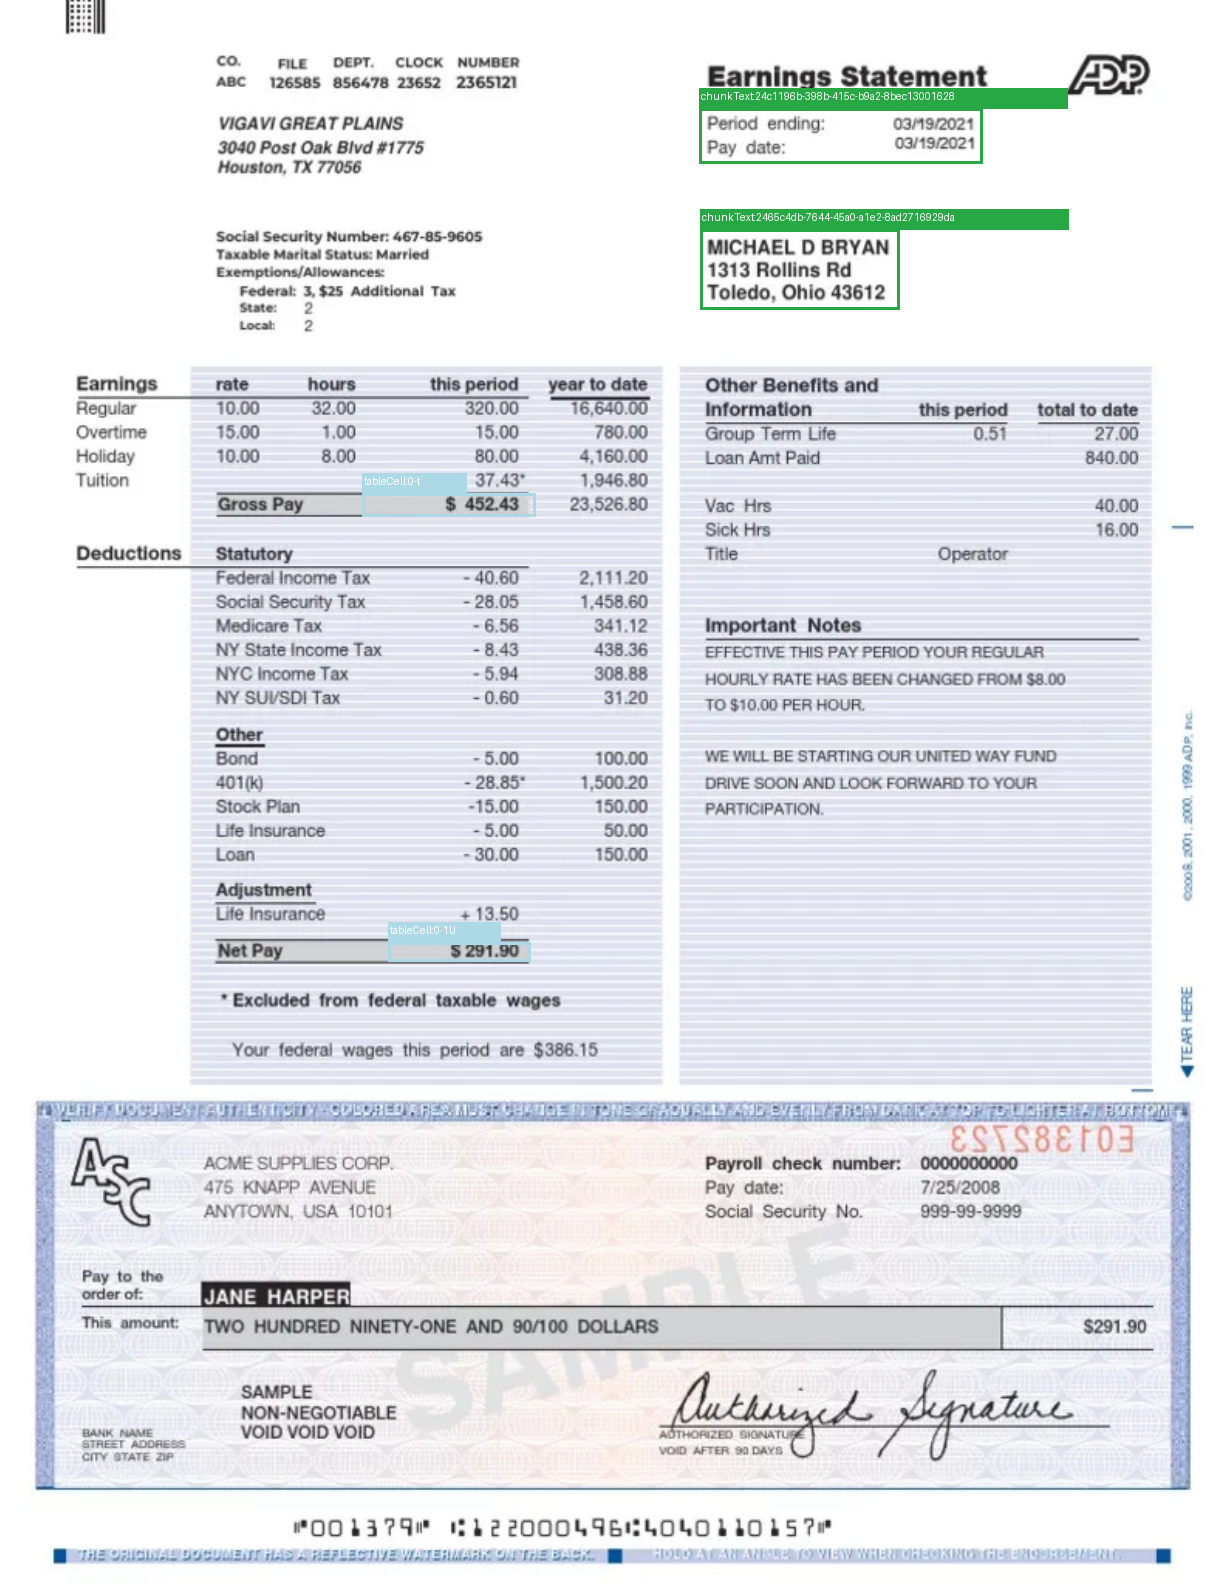

In [23]:
# Display all extracted field visualizations
from IPython.display import display

print("Extracted field visualizations for all documents:")
for result in Path("results_extracted").glob("**/page_*"):
    print(f"\n{result.parent.name}:")
    display(Image.open(result))

## ✅ Summary

You've successfully used LandingAI's Agentic Document Extraction to:
- ✓ Authenticate with the ADE API
- ✓ Automatically categorize mixed financial documents
- ✓ Parse documents to extract layout and content
- ✓ Define custom Pydantic schemas for different document types
- ✓ Extract structured financial data with visual grounding
- ✓ Visualize parsing and extraction results

### Key Takeaways

**Automatic Categorization**: ADE intelligently identifies document types, allowing you to process mixed document batches efficiently.

**Visual Grounding**: Every extracted value includes references to its source location, providing audit trails and enabling quick verification.

**Schema Flexibility**: Different document types can have completely different extraction schemas, applied automatically based on categorization.

**Structured Output**: All data is returned in structured JSON format, ready for import into tax software, databases, or spreadsheets.

### Next Steps

- Export extractions to CSV or database for tax preparation software
- Process additional document types (1099s, W-2s, receipts)
- Integrate with automated tax filing workflows
- Build custom validation rules based on extraction metadata

To learn more, visit the [LandingAI Documentation](https://docs.landing.ai/ade/ade-overview).